**Eugen Ehrlich im Web of Science und in OpenAlex**

This notebook ...

# Preparation

In [ ]:
# Uncomment and run once
# if you use vanilla python:
#   !pip install py2neo python-dotenv pandas pyvis
# OR if you use anaconda:
#   !conda install -c conda-forge py2neo python-dotenv
#   !conda install panda pyvis
# for table of contents support, see https://github.com/ipython-contrib/jupyter_contrib_nbextensions

Import the required libraries and setup needed objects:

In [ ]:
import os

# config
from dotenv import dotenv_values
config = {**dotenv_values()}

# https://py2neo.org/v4/
from py2neo import Graph, Node, Relationship
graph = Graph(config['NEO4J_URL'])

# visualization
from scripts.vis import draw, table

# clean up visualization HTML dir


# Web of Science

KB -> Neo4J

## Overview

In [ ]:
cypher = """
use `ehrlich-wos`
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen"
return count(distinct w1) as works_cited,
    count(distinct r2) as num_citations,
    count(distinct w2) as citing_works,
    count(distinct a2) as citing_authors
"""
graph.run(cypher).data()

## Cited works

In [ ]:
cypher = """
use `ehrlich-wos`
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen"
return distinct a1.display_name as author, w1.year as year, w1.title as title order by w1.year
"""
graph.run(cypher).to_data_frame()

## Citing works

In [ ]:
cypher = """
use `ehrlich-wos`
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen"
WITH w2, COLLECT(a2)[0] AS first_author
RETURN first_author.display_name AS author, w2.year AS year, w2.title AS title
ORDER BY w2.year
"""
graph.run(cypher).to_data_frame()

# OpenAlex

openalex.org -> neo4j

## Overview

In [ ]:
cypher = """
use `ehrlich-openalex`
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen"
return count(distinct w1) as works_cited,
    count(distinct r2) as num_citations,
    count(distinct w2) as citing_works,
    count(distinct a2) as citing_authors
"""
graph.run(cypher).data()

## Cited works
### All years

In [ ]:
query = """
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
match (w1)-[r4:PUBLISHED_IN]->(v1:Venue)
where a1.display_name = "ehrlich, eugen"
return distinct
    a1.display_name as author,
    w1.year as year,
    w1.title as title,
    v1.name as container,
    count(r2) as citations
order by citations desc
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(query).to_data_frame()

### Cited works (1960-1989)

In [ ]:
query = """
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen" and w2.year >= 1960 and w2.year <= 1990
return distinct
    a1.display_name as author,
    w1.year as year,
    w1.title as title,
    count(r2) as citations
order by citations desc
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(query).to_data_frame()

### Graph: Cited works, over time

OpenAlex seems not to distinguish between different editions of a work - e.g. ehrlich (1989) is cited even before publication. Also, book reviews are included (like the one by timasheff).

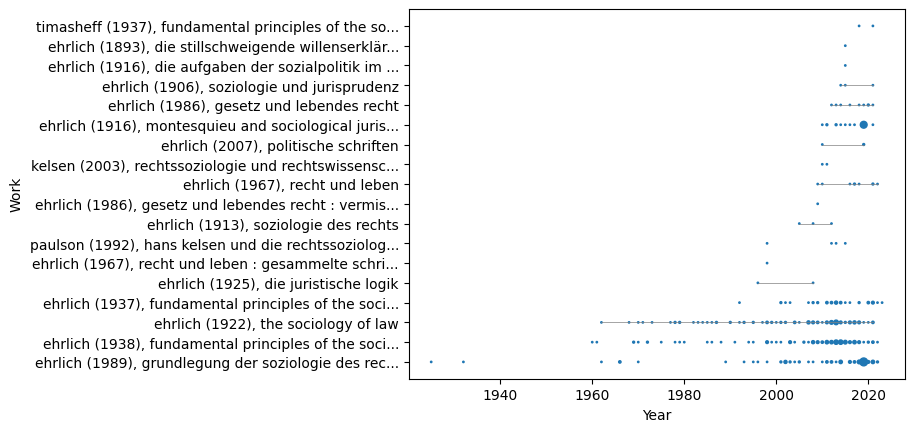

In [23]:
query = """
MATCH (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
WHERE citedAuthor.display_name = "ehrlich, eugen"
RETURN citedWork.display_name as work, citingWork.year as year, count(*) as citations
ORDER BY year
"""
from scripts.n4j_plotlib import plot_year_citations
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
data = graph.run(query).data()
plot_year_citations(data, dep_col='work', dep_label='Work')

### Percentage of cited works that were published before 1967

In [1]:
query = """
MATCH (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
WHERE citedAuthor.display_name = "ehrlich, eugen"
WITH COUNT(citedWork) AS totalWorks

MATCH (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
WHERE citedAuthor.display_name = "ehrlich, eugen" AND citedWork.year < 1967
WITH COUNT(citedWork) AS before1967Works, totalWorks

RETURN (toFloat(before1967Works) / totalWorks) * 100 AS percentage
"""
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
graph.run(query).to_table()


percentage
69.1747572815534


## Citing works
### Citing works (1960-1989)

In [ ]:
cypher = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen" and w2.year > 1967 and w2.year < 1990
WITH w1, w2, COLLECT(a2)[0] AS first_author
RETURN
    first_author.display_name AS author,
    w2.year AS year,
    w2.title AS title,
    w1.title as cited_work
ORDER BY w2.year
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(cypher).to_data_frame()

### Citing works (all years)

In [ ]:
cypher = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen"
WITH w1, w2, COLLECT(a2)[0] AS first_author
RETURN
    first_author.display_name AS author,
    w2.year AS year,
    w2.title AS title,
    w1.title as cited_work
ORDER BY w2.year
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(cypher).to_data_frame()

## Citing journals
### Citing journals, all years

In [ ]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)-[r3:PUBLISHED_IN]-(v1:Venue)
WHERE a1.display_name = "ehrlich, eugen"
with w1, v1, count(r2) as num_citations
where num_citations > 1
RETURN  v1.name AS container,
        num_citations,
        w1.title as cited_work
order by num_citations desc
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(query).to_data_frame()

### Graph: Citing journal, all years

In [ ]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)-[r3:PUBLISHED_IN]-(v1:Venue)
WHERE a1.display_name = "ehrlich, eugen"
with w1, v1, count(r2) as num_citations
where num_citations > 1
RETURN  v1 AS source_node,
        apoc.create.vRelationship(v1, 'CITATIONS', {value:num_citations}, w1) as rel,
        w1 as target_node
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
from scripts.pyvis import draw
draw(graph, query)

In [ ]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)-[r3:PUBLISHED_IN]-(v1:Venue)
WHERE a1.display_name = "ehrlich, eugen" and w2.year > 1960 and w2.year < 1990
with w1, v1, count(r2) as num_citations
where num_citations > 1
RETURN  v1 AS source_node,
        apoc.create.vRelationship(v1, 'CITATIONS', {value:num_citations}, w1) as rel,
        w1 as target_node
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
import scripts.pyvis
scripts.pyvis.draw(graph, query)

## Citing authors
### Citing authors, 1960-1989

In [ ]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen" and w2.year > 1960 and w2.year < 1990
with a1, a2, count(r2) as num_citations
order by num_citations
limit 10
with a2, collect
RETURN  a2, apoc.create.vRelationship(a2, 'CITES', {value:num_citations}, a1) as rel,a1
"""
from scripts.pyvis import draw
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
draw(graph, query)

### Graph: Citing authors, at least 3 citations over more than one year

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name <> ", " and a2.display_name = "ehrlich, eugen"
WITH a1, a2, count(r) as total_citations, collect(DISTINCT w1.year) as years
WHERE size(years) > 1 and total_citations >= 3
MATCH (a1)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2)
RETURN a1.display_name as author, w1.year as year, count(r) as citations
ORDER BY year
"""
from scripts.n4j_plotlib import plot_year_citations
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
data = graph.run(query).data()
plot_year_citations(data)


## Co-Citations

### Authors with most cocited works

In [ ]:
query = """
MATCH (citedAuthor:Author)-[:CREATOR_OF]->(citedWork:Work)<-[:CITES]-(citingWork:Work),
      (citingWork)-[:CITES]->(coCitedWork:Work)<-[:CREATOR_OF]-(coCitedAuthor:Author)
WHERE citedAuthor.display_name = "ehrlich, eugen" and coCitedAuthor.display_name <> ", "
WITH coCitedAuthor, COUNT(distinct coCitedWork) as coCitationCount
ORDER BY coCitationCount DESC
LIMIT 10
RETURN coCitedAuthor.display_name as Author,
    coCitationCount as CoCitationCount
"""
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
graph.run(query).to_table()

### Most cocited author that cite Ehrlich

In [ ]:
query="""
MATCH (citingWork:Work)-[:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author),
      (citingWork)-[coCitation:CITES]->(coCitedWork:Work)<-[:CREATOR_OF]-(coCitedAuthor:Author)
where citedAuthor.display_name = "ehrlich, eugen"
    and coCitedAuthor.display_name <> ", "
    and citedAuthor <> coCitedAuthor
    and exists((coCitedWork)-[:CITES]->(:Work)<-[:CREATOR_OF]-(citedAuthor))
WITH citedAuthor, coCitedAuthor,
    COUNT(distinct coCitation) as coCitationCount,
    collect(distinct citedWork) as citedWorks,
    collect(distinct coCitedWork) as coCitedWorks
ORDER BY coCitationCount DESC
LIMIT 10
call {
    with citedWorks, coCitedWorks
    unwind citedWorks as citedWork
    unwind coCitedWorks as coCitedWork
    MATCH (citingWork:Work)-[:CITES]->(citedWork)
    where exists((citingWork)-[:CITES]->(coCitedWork))
    with citedWork, count(citedWork) as citedWorkCitedCount
    ORDER BY citedWorkCitedCount DESC
    LIMIT 1
    return citedWork as mostCitedCitedWork
}
call {
    with citedWorks, coCitedWorks
    unwind citedWorks as citedWork
    unwind coCitedWorks as coCitedWork
    MATCH (citingWork:Work)-[:CITES]->(coCitedWork)
    where exists((citingWork)-[:CITES]->(citedWork))
    with coCitedWork, count(coCitedWork) as coCitationCitedCount
    ORDER BY coCitationCitedCount DESC
    LIMIT 1
    return coCitedWork as mostCitedCoCitedWork
}
return coCitedAuthor.display_name as `Co-cited author`,
    coCitationCount as `Number of co-citations`,
    mostCitedCitedWork.display_name as `Most cited work of cited author`,
    mostCitedCoCitedWork.display_name as `Most cited work of co-cited author`
"""
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
graph.run(query).to_table()


### Most co-cited authors with at least 10 years in which they were cocitated

In [ ]:
query="""
MATCH (citingWork:Work)-[:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author),
      (citingWork)-[coCitation:CITES]->(coCitedWork:Work)<-[:CREATOR_OF]-(coCitedAuthor:Author)
where citedAuthor.display_name = "ehrlich, eugen"
    and coCitedAuthor.display_name <> ", "
    and citedAuthor <> coCitedAuthor
WITH citedAuthor, coCitedAuthor,
    COUNT(distinct coCitation) as coCitationCount,
    collect(distinct citedWork) as citedWorks,
    collect(distinct coCitedWork) as coCitedWorks,
    collect(DISTINCT citingWork.year) as citingWorkYears
where size(citingWorkYears) > 10
with citedAuthor, coCitedAuthor, coCitationCount, citedWorks, coCitedWorks
ORDER BY coCitationCount DESC
LIMIT 10
call {
    with citedWorks, coCitedWorks
    unwind citedWorks as citedWork
    unwind coCitedWorks as coCitedWork
    MATCH (citingWork:Work)-[:CITES]->(citedWork)
    where exists((citingWork)-[:CITES]->(coCitedWork))
    with citedWork, count(citedWork) as citedWorkCitedCount
    ORDER BY citedWorkCitedCount DESC
    LIMIT 1
    return citedWork as mostCitedCitedWork
}
call {
    with citedWorks, coCitedWorks
    unwind citedWorks as citedWork
    unwind coCitedWorks as coCitedWork
    MATCH (citingWork:Work)-[:CITES]->(coCitedWork)
    where exists((citingWork)-[:CITES]->(citedWork))
    with coCitedWork, count(coCitedWork) as coCitationCitedCount
    ORDER BY coCitationCitedCount DESC
    LIMIT 1
    return coCitedWork as mostCitedCoCitedWork
}
return coCitedAuthor.display_name as `Co-cited author`,
    coCitationCount as `Number of co-citations`,
    mostCitedCitedWork.display_name as `Most cited work of cited author`,
    mostCitedCoCitedWork.display_name as `Most cited work of co-cited author`
"""
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
graph.run(query).to_table()


### Graph: Co-cited authors

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w:Work)-[:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
where a2.display_name = "ehrlich, eugen"
    and a1.display_name <> ", "
    and id(a1) <> id(a2)
WITH a1, a2, COUNT(distinct w1) as num_cocitations, collect(distinct w.year) as citingWorkYears
where size(citingWorkYears) > 10
with a1, a2, num_cocitations
ORDER BY num_cocitations DESC
LIMIT 10
CALL apoc.create.vRelationship(a1, "IS_COCITED_WITH", {count: num_cocitations, title: num_cocitations}, a2)
YIELD rel
RETURN a1, rel, a2
"""
from scripts.pyvis import draw
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
draw(graph, query, file="figure/ehrlich-co-citation-network.html", height="800px")

### Graph: Co-cited Authors, over time

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[r:CITES]-(w:Work)-[:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a2.display_name = "ehrlich, eugen"
    AND a1.display_name <> ", "
    and id(a1) <> id(a2)
    and exists((w1)-[:CITES]->(:Work)<-[:CREATOR_OF]-(a2))
WITH a1, w.year AS year, COUNT(r) AS num_citations
WITH a1, SUM(num_citations) AS total_citations
WHERE total_citations >= 3
WITH a1, total_citations
ORDER BY total_citations DESC
LIMIT 20
MATCH (a1)-[:CREATOR_OF]->(w1:Work)<-[r:CITES]-(w:Work)-[:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a2.display_name = "ehrlich, eugen"
    and id(a1) <> id(a2)
    and exists((w1)-[:CITES]->(:Work)<-[:CREATOR_OF]-(a2))
RETURN a1.display_name AS author, w.year AS year, COUNT(distinct r) AS citations
ORDER BY year
"""
from scripts.n4j_plotlib import plot_year_citations
from scripts.utils import get_graph
graph = get_graph("ehrlich-openalex")
data = graph.run(query).data()
plot_year_citations(data)

# Eigene Daten

Die Daten für die folgenden Abfragen wurden durch Zitationsextraktion aus den Volltexten der Zeitschrift für Rechtssoziologie, des Journal of Law and Society und einer Sammlung von Rechtssoziologie-Lehrbüchern zwischen 1960 und 1989 gewonnen. Sie sind aufgrund der maschinellen Extraktion in Teilen fehlerhaft und unvollständig. Jedoch sollten diese Fehler gleichmäßig verteilt sein und daher Ergebnisse verlässlich sein, die nicht einzelne Werte betreffen, sondern größere Trends ausdrücken.

## Zitierende Autor:innen, gesamter Zeitraum (Zeitreihe)

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
where tolower(a2.display_name) starts with "ehrlich, e"
RETURN a1.display_name as author, w1.year as year, count(r) as citations
ORDER BY year
"""

### ZfRsoz

In [ ]:
from scripts.n4j_plotlib import plot_year_citations
from scripts.utils import get_graph
data = get_graph("zfrsoz").run(query).data()
plot_year_citations(data)

### JLS

In [ ]:
data = get_graph("jls").run(query).data()
plot_year_citations(data)

## Zitierende Autor:innen, gesamter Zeitraum (Tabellen)

In [20]:
query = """
MATCH (citing_author:Author)-[:CREATOR_OF]->(citing_work:Work)-[citation:CITES]->(cited_work:Work)<-[:CREATOR_OF]-(cited_author:Author)
where (tolower(cited_author.display_name) starts with "ehrlich, e"
    or tolower(cited_work.title) contains "eugen ehrlich")
    //AND citing_work.year > 1960 and citing_work.year < 1990
WITH citing_author,
    collect(distinct citing_work) AS citing_works,
    collect(distinct cited_work) AS cited_works,
    count(citation) as num_citations
ORDER BY num_citations DESC
call {
    with citing_works
    unwind citing_works as citing_work
    MATCH (citing_work)-[citation:CITES]->(cited_work:Work)
    with citing_work, count(citation) as num_citations
    ORDER BY num_citations DESC
    LIMIT 1
    return citing_work as most_citing_work
}
call {
    with cited_works
    unwind cited_works as cited_work
    MATCH (citing_work:Work)-[citation:CITES]->(cited_work)<-[:CREATOR_OF]-(cited_author:Author)
    where tolower(cited_author.display_name) starts with "ehrlich, e"
    with cited_work, count(citation) as num_citations
    ORDER BY num_citations DESC
    return collect(cited_work) as most_cited_works_ehrlich
}
call {
    with cited_works
    unwind cited_works as cited_work
    MATCH (citing_work:Work)-[citation:CITES]->(cited_work)<-[:CREATOR_OF]-(cited_author:Author)
    where tolower(cited_work.title) contains "eugen ehrlich"
  //      and not tolower(cited_author.display_name) starts with "ehrlich, e"
    with cited_work, count(citation) as num_citations
    ORDER BY num_citations DESC
    return collect(cited_work) as most_cited_works_second_lit
}
RETURN citing_author.display_name AS Author,
    size(citing_works) as `Citing works`,
    most_citing_work.display_name AS `Most citing work`,
    size(most_cited_works_ehrlich) as `Cited works (Ehrlich)`,
    coalesce(most_cited_works_ehrlich[0].display_name, '') AS `Most cited (Ehrlich)`,
    size(most_cited_works_second_lit) as `Cited works (Second. lit.)`,
    coalesce(most_cited_works_second_lit[0].display_name, '') as `Most cited (Second. lit.)`
order by num_citations desc
limit 10
"""


### Zeitschrift für Rechtssoziologie

In [21]:
graph = get_graph("zfrsoz")
graph.run(query).to_table()

Author,Citing works,Most citing work,Cited works (Ehrlich),Most cited (Ehrlich),Cited works (Second. lit.),Most cited (Second. lit.)
"Haferkamp, Hans-Peter",1,haferkamp (2021): hermann kantorowicz’ vortrag auf dem ersten soziologentag 1910,5,ehrlich (1913): grundlegung der soziologie des rechts,0,
"Bora, Alfons",2,bora (2021): rechtssoziologie zwischen wissenschaft und social engineering. zum historischen verständnis interdisziplinärer reflexionsprobleme,2,ehrlich (1989): grundlegung der soziologie des rechts (1913),1,röhl (2013): 100 jahre rechtssoziologie: eugen ehrlichs rechtspluralismus heute
"Boehncke, Clemens",1,boehncke (2021): die ‚freirechtler‘ als intellektuellengruppe betrachtet,2,ehrlich (1907): die tatsachen des gewohnheitsrechts,2,rehbinder (1986): die begründung der rechtssoziologie durch eugen ehrlich
"Teubner, Günther",1,teubner (2015): exogene selbstbindung: wie gesellschaftliche teilsysteme ihre gründungsparadoxien externalisieren,0,,1,machura (2013): eugen ehrlichs rechtspluralis
"Feldmann, Malte",1,feldmann (2021): hans kelsens soziologieverständnis in den 1920er jahren: auch eine geschichte einer hinwendung?,0,,3,rehbinder (1986): die begründung der rechtssoziologie durch eugen ehrlich
"Scheffer, Thomas",1,scheffer (2015): diskurspraxis in recht und politik.,1,ehrlich (1989): grundlegung der soziologie des rechts,1,rehbinder (1986): die begründung der rechtssoziologie durch eugen ehrlich
"Egbert, Simon",1,egbert (2020): predictive policing als treiber rechtlicher innovation?,1,ehrlich (1913): grundlegung der soziologie des rechts,1,rottleuthner (2013): das lebende recht bei eugen ehrlich und ernst hirsch / living law in eugen ehrlich and ernst hirsch
"Maurer, Hans-Uhr!)",1,kocher (2013): rezensionen,0,,1,"lüderssen (2009): soziale gesetzgebungspolitik, freie rechtsfindung und soziologische rechtswissenschaft bei eugen ehrlich. nomos"
"Kocher, Eva",1,kocher (2013): rezensionen,0,,1,"lüderssen (2009): soziale gesetzgebungspolitik, freie rechtsfindung und soziologische rechtswissenschaft bei eugen ehrlich. nomos"
"Machura, Stefan",1,kocher (2013): rezensionen,0,,1,"lüderssen (2009): soziale gesetzgebungspolitik, freie rechtsfindung und soziologische rechtswissenschaft bei eugen ehrlich. nomos"


### Lehrbücher

In [ ]:
graph = get_graph("rsoz-lehrbuecher")
graph.run(query).to_table()

### JLS

In [ ]:
graph = get_graph("jls")
graph.run(query).to_table()

## Zitationsnetzwerk

In [9]:
query1 = """
MATCH p1=(a:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CITES]-(w3:Work)
WHERE tolower(a.display_name) starts with "ehrlich, e"
    AND w2.year < 1990 and w3.year < 1990
call {
    with w1
    SET w1.group = 'ehrlich'
}
RETURN p1
"""
query2 = """
match (a:Author)-[:CREATOR_OF]->(w1:Work), (a)-[:CREATOR_OF]->(w2:Work)
where tolower(a.display_name) starts with "ehrlich, e"
    //and w1.year > w2.year and w1.year <1989 and w2.year <1989
    and w1.title starts with "grundlegung"
    and (w2.title starts with "grundlegung" or w2.title starts with "fundamental")
return w1, w2, apoc.create.vRelationship(w1, 'SAME_AS', {group:"SAME_AS", hidden:true}, w2) as rel
"""


### Lehrbücher (1960-1989)

In [7]:
from scripts.pyvis import create_or_update_network, draw_network
from scripts.utils import get_graph
graph = get_graph("rsoz-lehrbuecher")
net = create_or_update_network(graph, query1, height="1000px")
net = create_or_update_network(graph, query2, net=net)
draw_network(net,file="docs/ehrlich-rsoz-lehrbuecher-network.html", link_only=True)

Hypothese: die Zitierung eines Werks von Ehrlich (w1) in einem Werk der Sekundärliteratur (w2) hat Auswirkung auf die Zitierung von (w1) in der (w2) zitierenden Literatur

In [7]:
query3 = """
MATCH p1=(a:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CITES]-(w3:Work),
    p2=(w3)-[:CITES]->(w1)
WHERE tolower(a.display_name) starts with "ehrlich, e"
    AND w2.year < 1990 and w3.year < 1990
RETURN p1, p2
"""
from scripts.pyvis import create_or_update_network, draw_network
from scripts.utils import get_graph
graph = get_graph("rsoz-lehrbuecher")
net = create_or_update_network(graph, query3, height="800px")
draw_network(net,file="docs/ehrlich-rsoz-lehrbuecher-network2.html", link_only=True)

### ZfRsoz (alle Jahre)

In [13]:
query4 = """
MATCH p1=(a:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CITES]-(w3:Work)
WHERE tolower(a.display_name) starts with "ehrlich, e"
call {
    with w1
    SET w1.group = 'ehrlich'
}
RETURN p1
"""
from scripts.pyvis import create_or_update_network, draw_network
from scripts.utils import get_graph
graph = get_graph("zfrsoz")
net = create_or_update_network(graph, query4, height="800px")
draw_network(net,file="docs/ehrlich-zfrsoz-network.html", link_only=True)

### JLS

In [18]:
query5 = """
MATCH p1=(a:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CITES]-(w3:Work)
WHERE tolower(a.display_name) starts with "ehrlich, e"
call {
    with w1
    SET w1.group = 'ehrlich'
}
RETURN p1
"""
from scripts.pyvis import create_or_update_network, draw_network
from scripts.utils import get_graph
graph = get_graph("jls")
net = create_or_update_network(graph, query5, height="800px")
draw_network(net,file="docs/ehrlich-jls-network.html", link_only=True)
